In [45]:
# 09_backtesting_senator.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os

os.makedirs("images", exist_ok=True)

# Load test set (unseen data)
df = pd.read_parquet(
    r"C:\Users\User\PycharmProjects\Project-Trading\data\scripts\data\test_set_senator1.parquet"
)

print(f"Test samples: {len(df)}")

# Load trained model
model = joblib.load(
    r"C:\Users\User\PycharmProjects\Project-Trading\scripts\models\senator_randomforest.pkl"
)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\PycharmProjects\\Project-Trading\\data\\scripts\\data\\test_set_senator1.parquet'

In [35]:
# 2. Features & Prediction

features = [
    'signed_amount', 'mean_amount', 'relative_trade_size',
    'tx_hour', 'tx_weekday',
    'price_before', 'vol_before', 'vwap_before', 'trade_count_before',
    'ema_5', 'ema_15', 'ema_30',
    'price_slope_15'
]

# Keep only existing features
features = [f for f in features if f in df.columns]

X = df[features]

# Model predicts absolute price movement (30min)
df['predicted_abs_move'] = np.abs(model.predict(X))

# Realized absolute movement
df['realized_abs_move'] = np.abs(df['price_change_pct'])

In [36]:

#3. Baseline definieren (Feedback vom Prof!)
#Baseline = durchschnittlicher 30min Return

baseline_return = df['realized_abs_move'].mean()
print(f"Baseline abs return (30min): {baseline_return:.4f}%")

#. Trading-Regel definieren
#Trade only when model expects strong reaction

# Threshold: top 20% predicted movements
threshold = df['predicted_abs_move'].quantile(0.80)

df['trade'] = df['predicted_abs_move'] > threshold

print(f"Trades taken: {df['trade'].sum()} ({df['trade'].mean()*100:.1f}%)")

Baseline abs return (30min): 0.0965%
Trades taken: 2 (22.2%)


In [37]:
#5. Strategie-Performance berechnen

# Strategy performance (only when trade=True)
strategy_returns = df.loc[df['trade'], 'realized_abs_move']

# Baseline performance (always average)
baseline_returns = pd.Series(
    baseline_return,
    index=strategy_returns.index
)

print("\n=== BACKTEST RESULTS ===")
print(f"Strategy mean abs return: {strategy_returns.mean():.4f}%")
print(f"Baseline mean abs return: {baseline_return:.4f}%")
print(f"Improvement: {strategy_returns.mean() - baseline_return:.4f}%")

if strategy_returns.mean() > baseline_return:
    print(" Strategy OUTPERFORMS baseline")
else:
    print("Strategy does NOT outperform baseline")


=== BACKTEST RESULTS ===
Strategy mean abs return: 0.1156%
Baseline mean abs return: 0.0965%
Improvement: 0.0191%
 Strategy OUTPERFORMS baseline


//OUTPUT//

=== BACKTEST RESULTS ===

Strategy mean abs return: 0.1156%

Baseline mean abs return: 0.0965%

Improvement: 0.0191%

 Strategy OUTPERFORMS baseline


In [38]:

#6. Performance pro Aktie (based on feedback of reviewsession)

print("\n=== PERFORMANCE PER STOCK ===")

for ticker, g in df[df['trade']].groupby('Ticker'):
    mean_ret = g['realized_abs_move'].mean()
    improvement = mean_ret - baseline_return

    print(f"{ticker}: mean={mean_ret:.4f}% | Δ={improvement:.4f}%")

#Referenz: "schauen ob manche Marken größere Auswirkungen durch Nachrichten haben“


=== PERFORMANCE PER STOCK ===
MSFT: mean=0.1156% | Δ=0.0191%


// OUTPUT

=== PERFORMANCE PER STOCK ===


MSFT: mean=0.1156% | Δ=0.0191%

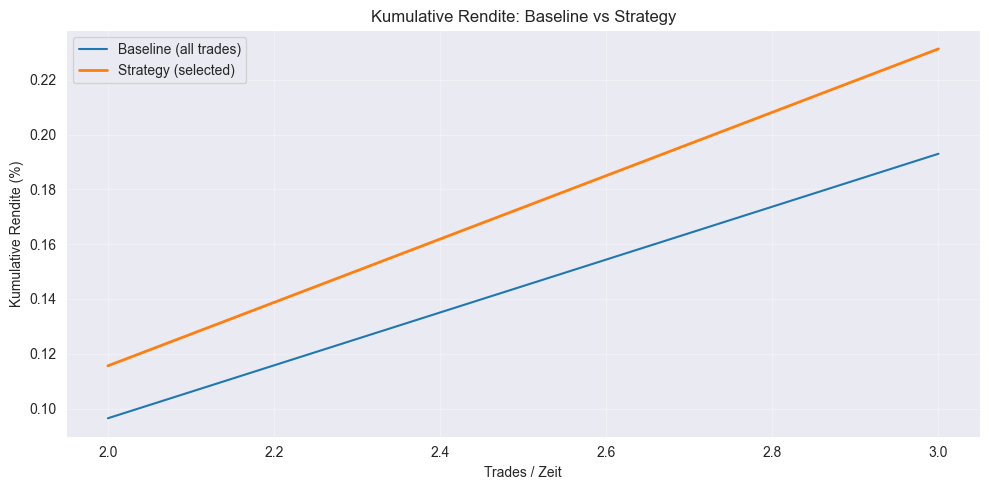

In [39]:
plt.figure(figsize=(10, 5))
# Annahme: baseline_returns und strategy_returns sind Zeitreihen
plt.plot(baseline_returns.cumsum(), label='Baseline (all trades)')
plt.plot(strategy_returns.cumsum(), label='Strategy (selected)', linewidth=2)
plt.title('Kumulative Rendite: Baseline vs Strategy')
plt.ylabel('Kumulative Rendite (%)')
plt.xlabel('Trades / Zeit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

below: keine klare Beziehung zwischen Vorhersage und tatsächlicher Rendite

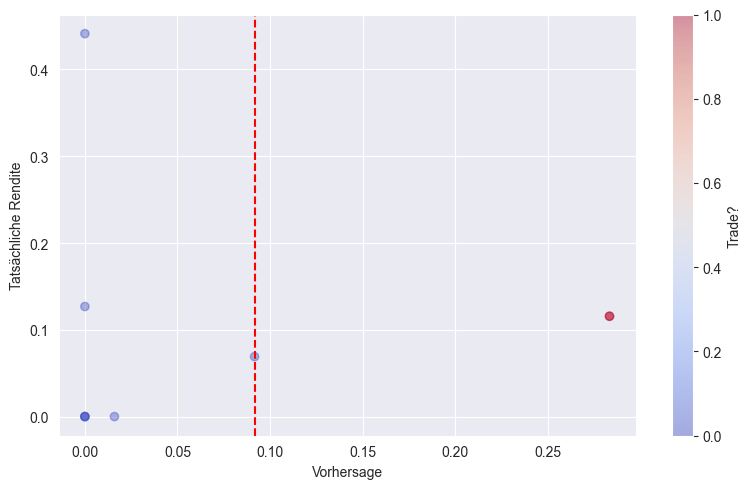

Schwelle: 0.092
Trades: 2/9
Alle: 0.0965
Selektiert: 0.1156


In [40]:
df['prediction'] = model.predict(df[features])

threshold = df['prediction'].quantile(0.75)
df['trade'] = df['prediction'] > threshold

plt.figure(figsize=(8,5))
plt.scatter(df['prediction'], df['realized_abs_move'],
            alpha=0.4, c=df['trade'], cmap='coolwarm')
plt.axvline(x=threshold, color='red', linestyle='--')
plt.xlabel('Vorhersage')
plt.ylabel('Tatsächliche Rendite')
plt.colorbar(label='Trade?')
plt.tight_layout()
plt.savefig('prediction_scatter.png', dpi=150)
plt.show()

print(f"Schwelle: {threshold:.3f}")
print(f"Trades: {df['trade'].sum():.0f}/{len(df)}")
print(f"Alle: {df['realized_abs_move'].mean():.4f}")
print(f"Selektiert: {df.loc[df['trade'], 'realized_abs_move'].mean():.4f}")

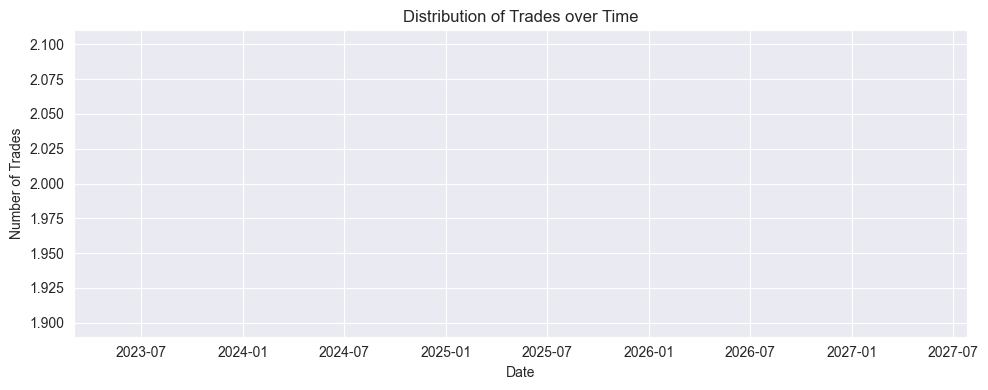

In [41]:

#8. Plot 2: Distribution of Trades over Time

plt.figure(figsize=(10, 4))
df[df['trade']]['TimeOfFiled'].dt.date.value_counts().sort_index().plot()
plt.title("Distribution of Trades over Time")
plt.xlabel("Date")
plt.ylabel("Number of Trades")
plt.tight_layout()
plt.savefig("images/09_trade_distribution.png", dpi=150)
plt.show()

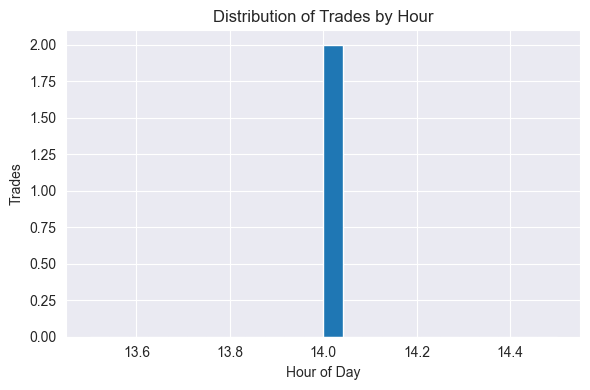

In [42]:
plt.figure(figsize=(6, 4))
df[df['trade']]['TimeOfFiled'].dt.hour.hist(bins=24)
plt.title("Distribution of Trades by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Trades")
plt.tight_layout()
plt.savefig("images/09_trade_hour_distribution.png", dpi=150)
plt.show()


In [43]:
print("\nMarket average abs move:", df['realized_abs_move'].mean())
print("Trade abs move:", df[df['trade']]['realized_abs_move'].mean())



Market average abs move: 0.09649105361574567
Trade abs move: 0.11562235958553425



Market average abs move: 0.09649105361574567

Trade abs move: 0.11562235958553425